## Dependent random variable

Some times simple stochastically independent random variables are not enough,
and one have to use variables with stochastic dependencies. In `chaospy` such
variables can be created through parameter declarations.

To demonstrate, let us start through example: a Gaussian distribution that
depend on a gamma distribution through its mu and sigma parameter:

In [9]:
import chaospy

dist1 = chaospy.Gamma(1)
dist2 = chaospy.Normal(mu=dist1, sigma=dist1+1)
joint = chaospy.J(dist1, dist2)

joint

J(Gamma(1), Normal(mu=Gamma(1), sigma=Add(Gamma(1), 1)))

The resulting distribution can be used as any other distribution in
`chaospy`. For example, here is the contour plot of the probability density
function together with (quasi-)random samples:

In [10]:
import numpy
from matplotlib import pyplot

grid = numpy.mgrid[0:3:100j, -3:4:100j]
pyplot.contourf(grid[0], grid[1], joint.pdf(grid), 30)
pyplot.scatter(*joint.sample(100, rule="halton"), marker="x")

pyplot.axis([0, 3, -3, 4])

(0.0, 3.0, -3.0, 4.0)

In `chaospy` dependencies are handled by assuming all distributions have a
known [chain rule
decomposition](https://en.wikipedia.org/wiki/Chain_rule_(probability)):

$$
p_{Q_1, Q_2, \dots}(q_1, q_2, \dots) =
      p_{Q_1}(q_1)\ p_{Q_2\mid Q_1}(q_2)\ p_{Q_3\mid Q_2=q_1,Q_2}(q_2)\cdots
$$

As long as this decomposition is possible, `chaospy` will figure out how to
assemble the joint density function, and random sampling. For examples, is
the following allowed:

In [11]:
dist_lo = chaospy.Uniform(0, 1)
dist_up = chaospy.Uniform(1, 2)
dist_mid = chaospy.Uniform(dist_lo, dist_up)
joint_ordered = chaospy.J(dist_lo, dist_mid, dist_up)

joint_ordered.sample(5, rule="halton").round(5)

array([[0.375  , 0.875  , 0.0625 , 0.5625 , 0.3125 ],
       [0.56722, 1.18889, 1.46472, 0.60981, 0.59676],
       [1.24   , 1.44   , 1.64   , 1.84   , 1.08   ]])

or visually:

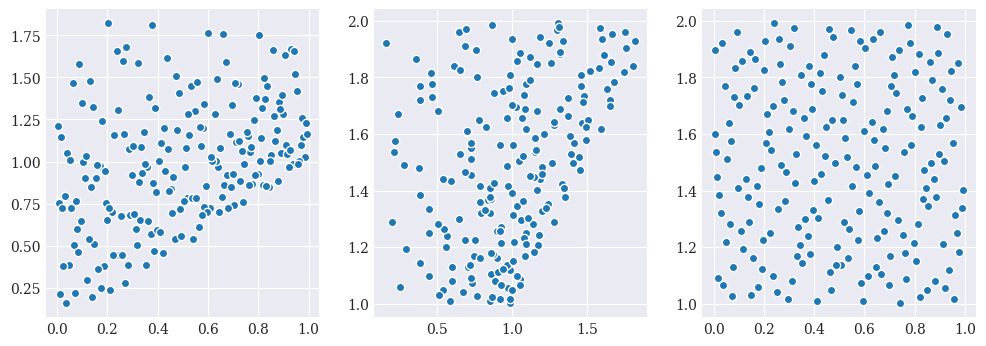

In [12]:
samples = joint_ordered.sample(200, rule="halton")

pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(131)
pyplot.scatter(samples[0], samples[1])
pyplot.subplot(132)
pyplot.scatter(samples[1], samples[2])
pyplot.subplot(133)
pyplot.scatter(samples[0], samples[2])

pyplot.show()

Having random samples and probability density function available, allows for
use of [generalized polynomial chaos](./generalized_polynomial_chaos.ipynb).

### Limitations

The functionality described above allows for creating the joint probability
density function and joint random samples. In practice the latter is possible
because `chaospy` constructs the forward and inverse *Rosenblatt
transformation*. However, it is important to note that dependent random
variables likes these can not be used for everything. For example, when
creating quadrature nodes and weights, rules not dependent on distributions,
like Fejér, works fine:

In [13]:
nodes, weights = chaospy.generate_quadrature(2, joint, rule="fejer_2")
nodes.round(4), weights.round(6)

(array([[  4.721 ,   4.721 ,   4.721 ,  16.1185,  16.1185,  16.1185,
          27.516 ,  27.516 ,  27.516 ],
        [ 37.7152, 148.6125, 259.5099,  37.7152, 148.6125, 259.5099,
          37.7152, 148.6125, 259.5099]]),
 array([2.00850e-02, 0.00000e+00, 0.00000e+00, 8.51019e-01, 0.00000e+00,
        0.00000e+00, 8.00000e-06, 0.00000e+00, 0.00000e+00]))

However, rules that directly is built on properties taken from the
distributions, and in particular, those assuming stochastic independence, can
not work. For example optimal Gaussian quadrature:

In [14]:
import pytest

with pytest.raises(chaospy.StochasticallyDependentError):
    chaospy.generate_quadrature(2, joint, rule="gaussian")

The same limitation also prevents the construction of joint *cumulative
distribution function*.

### Illegal distribution

Note that the distribution of interest here, `joint` is the joint
distribution including both the Gaussian and the Gamma distribution. The
conditional Gaussian distribution `dist2` is created and part of this, but on
its own can not be used for anything. In fact, trying to use conditional
distributions in `chaospy` will cause an error:

In [15]:
with pytest.raises(chaospy.StochasticallyDependentError):
    dist2.sample(10)

In other words, though any dependencies can be modeled in `chaospy`,
declaring those distributions might sometimes be challenging. For example, a
transformation like:

In [16]:
dist1 = chaospy.Uniform(0, 1)
dist2 = chaospy.Normal(0, 1)
joint_illegal = chaospy.J(dist1+dist2, dist1-dist2)

with pytest.raises(chaospy.StochasticallyDependentError):
    joint_illegal.sample(10)